## Setup

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v1")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a deprecated ali

## Environment

In [2]:
# Run a demo of the environment
observation = env.reset()
cum_reward = 0
cart_frames = []
for t in range(5000):
    # Render into buffer. 
    cart_frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    if done:
        break

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/jovyan/.local/lib/python3.8/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/home/jovyan/.local/lib/python3.8/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Display

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


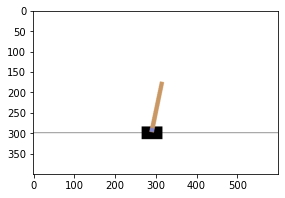

In [3]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots(figsize = (5, 3))
im = ax.imshow(cart_frames[0])
def updatefig(frame):
    im.set_array(cart_frames[frame])
    return im,
anim = animation.FuncAnimation(fig, updatefig, 
                             frames = range(1, len(cart_frames)), interval=120, blit=True)
anim

## Network

In [4]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training

In [5]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        template = "Solved at episode {} with reward {:.2f}!"
        print(template.format(episode_count, running_reward))
        break

running reward: 14.43 at episode 10
running reward: 31.07 at episode 20
running reward: 45.13 at episode 30
running reward: 52.28 at episode 40
running reward: 53.40 at episode 50
running reward: 62.15 at episode 60
running reward: 70.41 at episode 70
running reward: 128.81 at episode 80
running reward: 102.36 at episode 90
running reward: 73.83 at episode 100
running reward: 55.72 at episode 110
running reward: 51.31 at episode 120
running reward: 49.45 at episode 130
running reward: 93.12 at episode 140
Solved at episode 146 with reward 197.56!


## Inference

In [6]:
cart_frames2 = []
episode_count = 0
while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))

            # Apply the sampled action in our environment
            cart_frames2.append(env.render(mode='rgb_array'))
            state, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward


    if running_reward > 190:  # Condition to consider the task solved
        template = "Episode {} with reward {:.2f}!"
        print(template.format(episode_count, running_reward))
        break

/home/jovyan/.local/lib/python3.8/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 0 with reward 212.69!


## Display

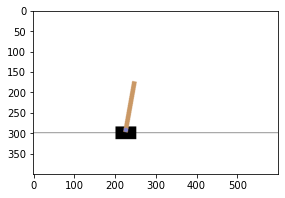

In [7]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots(figsize = (5, 3))
im = ax.imshow(cart_frames2[0])
def updatefig(frame):
    im.set_array(cart_frames2[frame])
    return im,
anim = animation.FuncAnimation(fig, updatefig, 
                             frames = range(1, len(cart_frames2)), interval=120, blit=True)
anim